Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Melanoma_Assignment/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Melanoma_Assignment/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    subset=None,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.


In [13]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 118 files belonging to 9 classes.


In [14]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

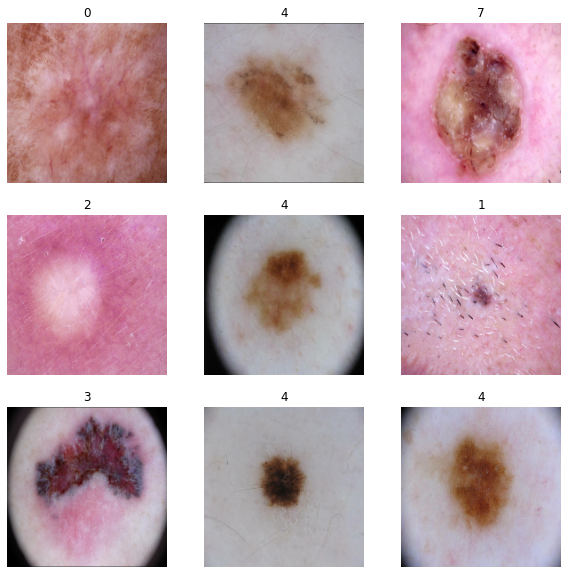

In [16]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [29]:
### Your code goes here
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

model = Sequential()
model.add(Rescaling(1.0 / 255))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_height, img_width)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(BatchNormalization())
model.add(Dense(len(class_names), activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [30]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
# View the summary of all layers
model.build((None,180,180,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_3 (Conv2D)           (None, 176, 176, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 88, 88, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 88, 88, 64)      

### Train the model

In [32]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 4s 42ms/step - loss: 2.1382 - accuracy: 0.4163 - val_loss: 2.4602 - val_accuracy: 0.1356
Epoch 2/20
70/70 [==============================] - 3s 41ms/step - loss: 1.3406 - accuracy: 0.5409 - val_loss: 2.7276 - val_accuracy: 0.1356
Epoch 3/20
70/70 [==============================] - 3s 41ms/step - loss: 1.1424 - accuracy: 0.6047 - val_loss: 2.6791 - val_accuracy: 0.1356
Epoch 4/20
70/70 [==============================] - 3s 41ms/step - loss: 1.0067 - accuracy: 0.6583 - val_loss: 2.8485 - val_accuracy: 0.1356
Epoch 5/20
70/70 [==============================] - 3s 41ms/step - loss: 0.8360 - accuracy: 0.7289 - val_loss: 2.5911 - val_accuracy: 0.1610
Epoch 6/20
70/70 [==============================] - 3s 41ms/step - loss: 0.6441 - accuracy: 0.7829 - val_loss: 2.7240 - val_accuracy: 0.1695
Epoch 7/20
70/70 [==============================] - 3s 41ms/step - loss: 0.4694 - accuracy: 0.8575 - val_loss: 2.3146 - val_accuracy: 0.2034
Epoch 8/20
70

### Visualizing training results

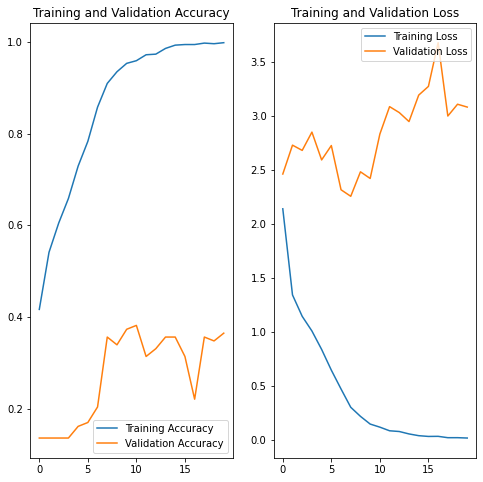

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

There is significant model overfitting. Train and Validation metrics are too far apart. I have added Batchnormalization to stabilize the gradients as the results were much worse without batch normalization. Will try Dropout next to mitigate overfitting

In [34]:
model = Sequential()
model.add(Rescaling(1.0 / 255))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_height, img_width)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(class_names), activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.build((None,180,180,3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 178, 178, 32)     128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 178, 178, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 176, 176, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 88, 88, 64)       0         
 2D)                                                  

In [35]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 4s 49ms/step - loss: 2.0422 - accuracy: 0.3828 - val_loss: 2.5270 - val_accuracy: 0.1356
Epoch 2/20
70/70 [==============================] - 3s 47ms/step - loss: 1.4655 - accuracy: 0.4895 - val_loss: 2.8424 - val_accuracy: 0.1356
Epoch 3/20
70/70 [==============================] - 3s 47ms/step - loss: 1.2963 - accuracy: 0.5610 - val_loss: 2.5630 - val_accuracy: 0.1356
Epoch 4/20
70/70 [==============================] - 3s 47ms/step - loss: 1.1833 - accuracy: 0.5913 - val_loss: 2.7450 - val_accuracy: 0.1356
Epoch 5/20
70/70 [==============================] - 3s 47ms/step - loss: 1.0529 - accuracy: 0.6289 - val_loss: 2.7049 - val_accuracy: 0.2119
Epoch 6/20
70/70 [==============================] - 3s 47ms/step - loss: 0.9108 - accuracy: 0.6869 - val_loss: 2.4795 - val_accuracy: 0.1949
Epoch 7/20
70/70 [==============================] - 3s 47ms/step - loss: 0.7658 - accuracy: 0.7338 - val_loss: 2.7378 - val_accuracy: 0.1780
Epoch 8/20
70

**Visualizing the results after Dropout**

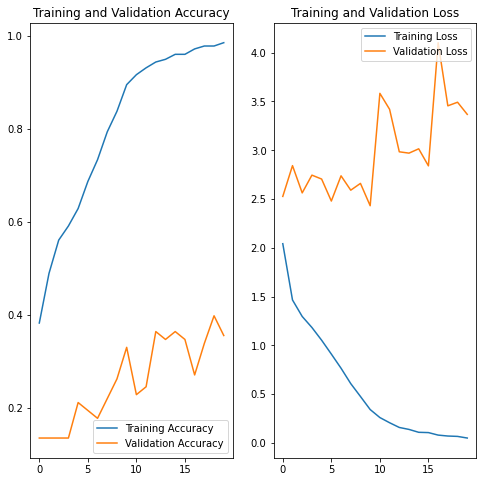

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The improvement is mild but insignificant. We need to explore image augmentation strategies next

In [38]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

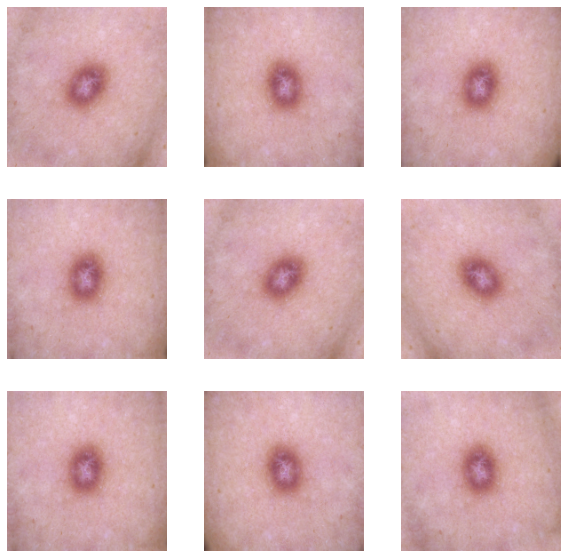

In [39]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in val_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [42]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
from tensorflow.keras.layers import RandomFlip, RandomRotation

model = Sequential()
model.add(RandomFlip("horizontal"))
model.add(RandomRotation(0.1))
model.add(Rescaling(1.0 / 255))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_height, img_width)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(class_names), activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.build((None,180,180,3))
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 178, 178, 32)     128       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 178, 178, 32)     

In [43]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 4s 50ms/step - loss: 1.9521 - accuracy: 0.3703 - val_loss: 2.3653 - val_accuracy: 0.1356
Epoch 2/20
70/70 [==============================] - 3s 48ms/step - loss: 1.5185 - accuracy: 0.4806 - val_loss: 2.4654 - val_accuracy: 0.1356
Epoch 3/20
70/70 [==============================] - 3s 48ms/step - loss: 1.4275 - accuracy: 0.4993 - val_loss: 2.5281 - val_accuracy: 0.1356
Epoch 4/20
70/70 [==============================] - 3s 48ms/step - loss: 1.3271 - accuracy: 0.5319 - val_loss: 2.6253 - val_accuracy: 0.1356
Epoch 5/20
70/70 [==============================] - 3s 48ms/step - loss: 1.2925 - accuracy: 0.5565 - val_loss: 2.5368 - val_accuracy: 0.1356
Epoch 6/20
70/70 [==============================] - 3s 48ms/step - loss: 1.2334 - accuracy: 0.5699 - val_loss: 2.4404 - val_accuracy: 0.1864
Epoch 7/20
70/70 [==============================] - 3s 48ms/step - loss: 1.2157 - accuracy: 0.5583 - val_loss: 2.0271 - val_accuracy: 0.2712
Epoch 8/20
70

### Visualizing the results

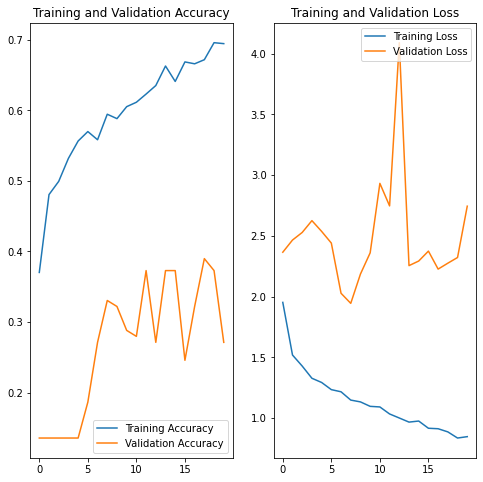

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

There is a mild improvement in the validation metrics. The gradient of improvement is consistent. However, this is still insignification

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [53]:
## Your code goes here.
from collections import Counter
t = []
for _, y in train_ds:
  t += list(y.numpy())


print(Counter(t))

Counter({5: 462, 3: 438, 1: 376, 4: 357, 7: 181, 8: 139, 0: 114, 2: 95, 6: 77})


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

Class 6 is the least represented of all, where as class 5 is the dominant one


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [54]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [59]:
path_to_training_dataset="/content/drive/MyDrive/Colab Notebooks/Melanoma_Assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + str(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_Assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9182190CD0>: 100%|██████████| 500/500 [00:08<00:00, 55.98 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_Assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F916471D110>: 100%|██████████| 500/500 [00:08<00:00, 56.88 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_Assignment/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9182062610>: 100%|██████████| 500/500 [00:08<00:00, 56.37 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_Assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F91685F2E90>: 100%|██████████| 500/500 [00:44<00:00, 11.30 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_Assignment/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7F9164F43450>: 100%|██████████| 500/500 [00:43<00:00, 11.46 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_Assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9163516F50>: 100%|██████████| 500/500 [00:08<00:00, 55.60 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_Assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F91FE3BF290>: 100%|██████████| 500/500 [00:20<00:00, 24.56 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_Assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F91822F4950>: 100%|██████████| 500/500 [00:09<00:00, 55.44 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_Assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9163507A90>: 100%|██████████| 500/500 [00:09<00:00, 54.36 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [60]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### **Todo**: Train the model on the data created using Augmentor

In [61]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [62]:
data_dir_train="/content/drive/MyDrive/Colab Notebooks/Melanoma_Assignment/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [63]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [64]:
## your code goes here
model = Sequential()
model.add(Rescaling(1.0 / 255))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_height, img_width)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(class_names), activation='softmax'))



#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [65]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.build((None,180,180,3))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_9 (Batc  (None, 178, 178, 32)     128       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 178, 178, 32)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 176, 176, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 88, 88, 64)       0         
 2D)                                                  

#### **Todo:**  Train your model

In [66]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 20s 113ms/step - loss: 1.8092 - accuracy: 0.3757 - val_loss: 2.8666 - val_accuracy: 0.1166
Epoch 2/50
169/169 [==============================] - 20s 116ms/step - loss: 1.3248 - accuracy: 0.5261 - val_loss: 2.8675 - val_accuracy: 0.1203
Epoch 3/50
169/169 [==============================] - 19s 111ms/step - loss: 1.0819 - accuracy: 0.6126 - val_loss: 1.9066 - val_accuracy: 0.2621
Epoch 4/50
169/169 [==============================] - 19s 111ms/step - loss: 0.8662 - accuracy: 0.7014 - val_loss: 1.8049 - val_accuracy: 0.3615
Epoch 5/50
169/169 [==============================] - 19s 111ms/step - loss: 0.6148 - accuracy: 0.7943 - val_loss: 2.7789 - val_accuracy: 0.2910
Epoch 6/50
169/169 [==============================] - 19s 111ms/step - loss: 0.4529 - accuracy: 0.8468 - val_loss: 1.7810 - val_accuracy: 0.4432
Epoch 7/50
169/169 [==============================] - 20s 112ms/step - loss: 0.3152 - accuracy: 0.8961 - val_loss: 1.8191 - val_ac

#### **Todo:**  Visualize the model results

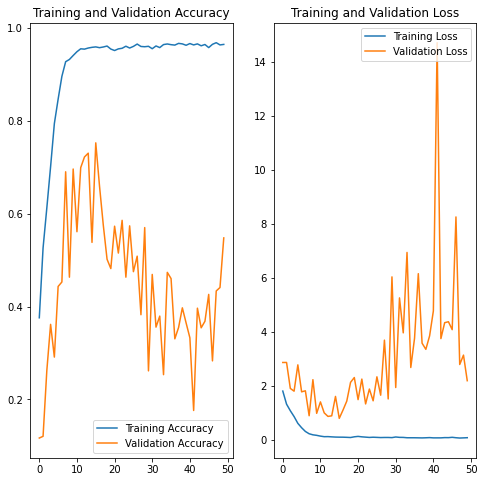

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Overfitting due to imbalance has been reduced significantly. We are seeing best performance out of all the attempts now after class rebalancing. There is still overfitting due to over training. We see that Epoch 16 has the best results of all, so we may use earlystopping and modelcheckpoint to save parameters from the best epoch